# Import library

In [1]:
import numpy as np
import pandas as pd
import pyapep_storage2 as pa
import matplotlib.pyplot as plt
import pyiast

# Isotherm Data

## Key Information

In [2]:
par_ch4 = [9.32093069e+01, 1.97408443e-02, 7.28430737e-03] # Based on mol/kg vs bar
par_n2 = [1.44368426e+02, 1.12248265e-02] # Based on mol/kg vs bar

dH_list = [9.49951172, 6.00173301] ## kJ
T_ref_list = [180.0,180.0]  ## K

rho_solid = 211.978      ## kg/m^3

def Lang(p_in,par):
    qtmp = par[0] * par[1]*p_in/(1+par[1]*p_in)
    return qtmp

def Quad(p_in,par):
    qtmp = par[0]*(par[1]*p_in+2*par[2]*p_in**2)/(1+par[1]*p_in + par[2]*p_in**2)
    return qtmp

def DSLa(p_in,par):
    qtmp1 = par[0]*par[2]*p_in/(1+par[2]*p_in)
    qtmp2 = par[1]*par[3]*p_in/(1+par[3]*p_in)
    qtmp_return = qtmp1 + qtmp2
    return qtmp_return

Text(0.5, 1.0, 'N2 dummy')

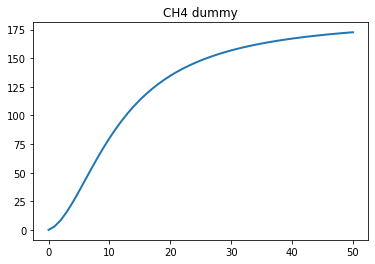

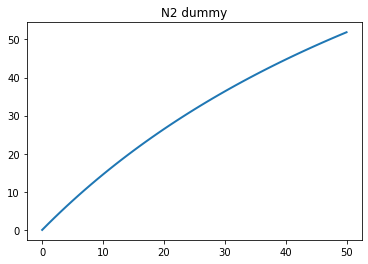

In [3]:
## CH4 Case ##
p_test = np.linspace(0,50, 51)
qch4_test = Quad(p_test,par_ch4)
di_ch4 = {'p':p_test,'q':qch4_test}
df_ch4 = pd.DataFrame(di_ch4)

plt.figure()
plt.plot(p_test,qch4_test,linewidth = 2)
plt.title('CH4 dummy')


## N2 Case ##
p_test = np.linspace(0,50, 51)
qn2_test = Lang(p_test,par_n2)
di_n2 = {'p':p_test,'q':qn2_test}
df_n2 = pd.DataFrame(di_n2)

plt.figure()
plt.plot(p_test,qn2_test,linewidth = 2)
plt.title('N2 dummy')

## Fitting with pyiast

In [4]:
iso0 = pyiast.ModelIsotherm(df_ch4,
                            loading_key='q',pressure_key = 'p',
                            model= 'Quadratic', 
                            param_guess = {
                                'M': par_ch4[0],
                                'Ka':par_ch4[1],
                                'Kb':par_ch4[2]
                                })
print(iso0.params)

iso1 = pyiast.ModelIsotherm(df_n2,
                            loading_key='q',pressure_key = 'p',
                            model= 'Langmuir', 
                            param_guess = {'M': par_n2[0],
                                           'K': par_n2[1],
                                           })
print(iso1.params)
iso_pyiast = [iso0, iso1]

{'M': 93.2093069, 'Ka': 0.0197408443, 'Kb': 0.00728430737}
{'M': 144.368426, 'K': 0.0112248265}


# Test Storage Tank Model

In [5]:
### Conditions ###

# %% Feed conditions
# Inlet conditions ?
feed_composition = [0.995,0.005]
T_inlet = 300 # K

# %% Heat capacity info
# Heat related properties (methane; nitrogen) + (zeolite)
Cp_g = np.array([40.63,29.22])  # Gas heat capacity: J/mol/K
Cp_s = 850                      # Solid heat capacity: J/kg/K
#Cp_s = 948                      # Solid heat capacity: J/kg/K

x_gas = [0.995,0.005]
T_current = [298]
#T_current = [250]
P_init = 1
P_norm = np.exp(np.array(dH_list)*1000/8.3145*(1/np.array(T_current) - 1/np.array(T_ref_list)))*x_gas*P_init
q_init_eq = pyiast.iast(P_norm,[iso0,iso1],)
print('[q_inti_1, q_init_2] = ')
print(q_init_eq)
#q_solid = [0.0,0.0]
q_solid = list(q_init_eq)

initial_variables = x_gas + q_solid + T_current


[q_inti_1, q_init_2] = 
[0.15689234 0.0017012 ]


In [6]:
Result_test = pa.storage_tank(feed_composition,iso_pyiast,dH_list,T_ref_list,
                              initial_variables,P_in=3, T_in = T_inlet)
Perf_test = pa.Massbal_interation(Result_test.x[0:2], Result_test.x[2],
                                  feed_composition,iso_pyiast,dH_list,T_ref_list,
                                  initial_variables,P_in=3, T_in = T_inlet)
print(Perf_test)

(1938.1291423974667, array([0.34088145, 0.00166944]), 0, array([ True,  True]))


# For different pressure and temperature

## Import Feed Conditions

[314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314.
 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314.
 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314.
 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314.
 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314.
 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314.
 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314. 314.
 314. 314.]
[  3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.  42.
  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.  84.
  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123. 126.
 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165. 168.
 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207. 210.
 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249. 252.
 255. 258. 261. 264. 267. 270. 273. 276. 279. 282. 285. 288. 291.

Text(0.5, 1.0, 'Feed Conditions After Compressor')

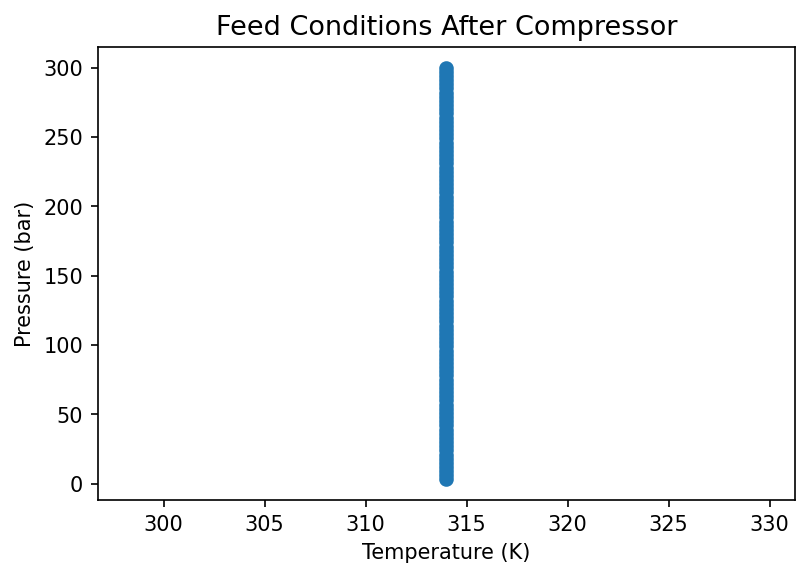

In [7]:
Pfeed_arr = np.linspace(3,300, 99+1)
Tfeed_arr = 314*np.ones(len(Pfeed_arr))
print(Tfeed_arr)
print(Pfeed_arr)

## Graph ##
plt.figure(dpi =150)
plt.plot(Tfeed_arr,Pfeed_arr, 'o')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (bar)')
plt.title('Feed Conditions After Compressor',fontsize = 13)

In [9]:
del_M_list = []
T_fin_list = []
L = 5
A = 3.1416
epsi = 0.4
Mmolar = np.array([0.016, 0.028])       # kg/mol
M_av = np.sum(np.array(x_gas)*Mmolar)   # kg/mol
Design_spec = {'A': A, 'L':L,'rho_s':rho_solid, 'epsi':0.4}
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.028])) # kg/mol [CH4, N2]
M_ad = (rho_solid*L*A*(1-epsi))

ind1_tmp =37
ind2_tmp =-1
PP_tmp1 = Pfeed_arr[ind1_tmp]
TT_tmp1 = Tfeed_arr[ind1_tmp]
PP_tmp2 = Pfeed_arr[ind2_tmp]
TT_tmp2 = Tfeed_arr[ind2_tmp]
print(PP_tmp1, 'bar &', TT_tmp1, 'K')
print(PP_tmp2, 'bar &', TT_tmp2, 'K')
print()
re_tmp1 = pa.storage_tank(feed_composition,iso_pyiast, dH_list, T_ref_list,
                          initial_variables,
                          P_in = PP_tmp1, T_in=TT_tmp1,
                          Design=Design_spec)  
    
Perf_tmp1 = pa.Massbal_interation(re_tmp1.x[0:2], re_tmp1.x[2],
                                  feed_composition,iso_pyiast,
                                  dH_list,T_ref_list,
                                  initial_variables, P_in = PP_tmp1, T_in = TT_tmp1,
                                  Design=Design_spec)
# @ 100 bar : kg CH4 / kg MOF
mol_tmp1 = Perf_tmp1[0]
kg_tmp1 = Mw_av*mol_tmp1
kgkg_tmp1 = kg_tmp1/M_ad

T_tmp1 = re_tmp1.x[2]


re_tmp2 = pa.storage_tank(feed_composition,iso_pyiast, dH_list, T_ref_list,
                          initial_variables,
                          P_in = PP_tmp2, T_in=TT_tmp2,
                          Design=Design_spec)  
Perf_tmp2 = pa.Massbal_interation(re_tmp2.x[0:2], re_tmp2.x[2],
                                  feed_composition,iso_pyiast,
                                  dH_list,T_ref_list,
                                  initial_variables, P_in = PP_tmp2, T_in = TT_tmp2,
                                  Design=Design_spec)
# @ 300 bar : kg CH4 / kg MOF
mol_tmp2 = Perf_tmp2[0]
kg_tmp2 = Mw_av*mol_tmp2
kgkg_tmp2 = kg_tmp2/M_ad

T_tmp2 = re_tmp2.x[2]
print()
print('||  Storage RESULT : @ 100bar & @ 300bar ||')
print()

#print('{0:8f}'.format(kgkg_tmp1), ' kg NG/kg MOF')
#print('{0:8f}'.format(kgkg_tmp2), ' kg NG/kg MOF')
print('{0:8f}'.format(kgkg_tmp1))
print('{0:8f}'.format(kgkg_tmp2))
print()
print('|| Delta T RESULT: @ 100bar & @ 300bar ||')
print()
print('{0:8f}'.format(T_tmp1))
print('{0:8f}'.format(T_tmp2))

114.0 bar & 314.0 K
300.0 bar & 314.0 K

SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!

||  Storage RESULT : @ 100bar & @ 300bar ||

0.352536
0.979072

|| Delta T RESULT: @ 100bar & @ 300bar ||

91.421536
124.205280


## Run Storage Model

In [8]:
del_M_list = []
T_fin_list = []
L = 5
A = 3.1416
epsi = 0.4
Mmolar = np.array([0.016, 0.028])       # kg/mol
M_av = np.sum(np.array(x_gas)*Mmolar)   # kg/mol
Design_spec = {'A': A, 'L':L,'rho_s':rho_solid, 'epsi':0.4}
for T_ff, P_ff in zip(Tfeed_arr, Pfeed_arr):
    Result_tmp = pa.storage_tank(feed_composition,iso_pyiast, dH_list,T_ref_list,
                                initial_variables, 
                                P_in = P_ff, T_in = T_ff,
                                Design=Design_spec)
    Perf_tmp = pa.Massbal_interation(Result_tmp.x[0:2], Result_tmp.x[2],
                                     feed_composition,iso_pyiast,
                                     dH_list,T_ref_list,
                                     initial_variables, P_in = P_ff, T_in = T_ff,
                                     Design=Design_spec)
    del_M_list.append(Perf_tmp[0])
    T_fin_list.append(Result_tmp.x[2])

C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differe

C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


Differential Evolution IS PICKED !!!
SHGO METHOD IS USED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!


## Graph (Storage)

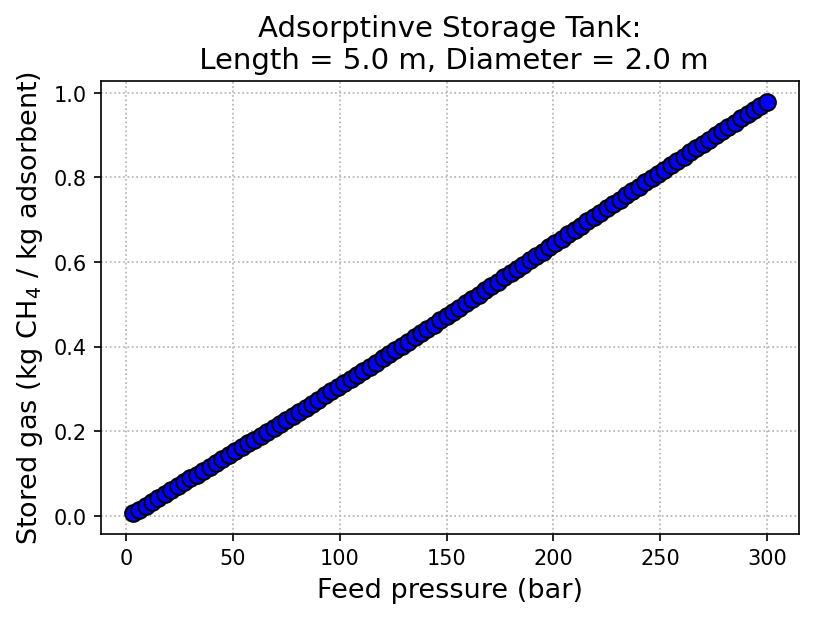

In [9]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.028])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, del_M_kg / (rho_solid*L*A*(1-epsi)),
         'o', color = 'k',markersize = 8, mfc = 'b')
plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('Stored gas (kg CH$_{4}$ / kg adsorbent)', fontsize = 13)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

## Graph (Temperature)

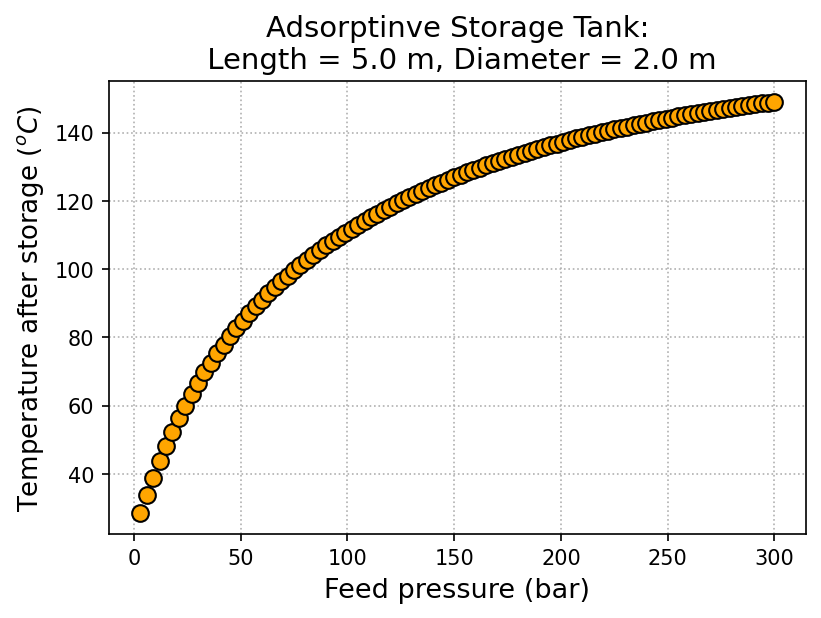

In [10]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, np.array(T_fin_list) + T_current[0] - 273.15,
         'o', color = 'k',markersize = 8,mfc = 'orange')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('Temperature after storage ($^{o}C$)', fontsize = 12.5)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

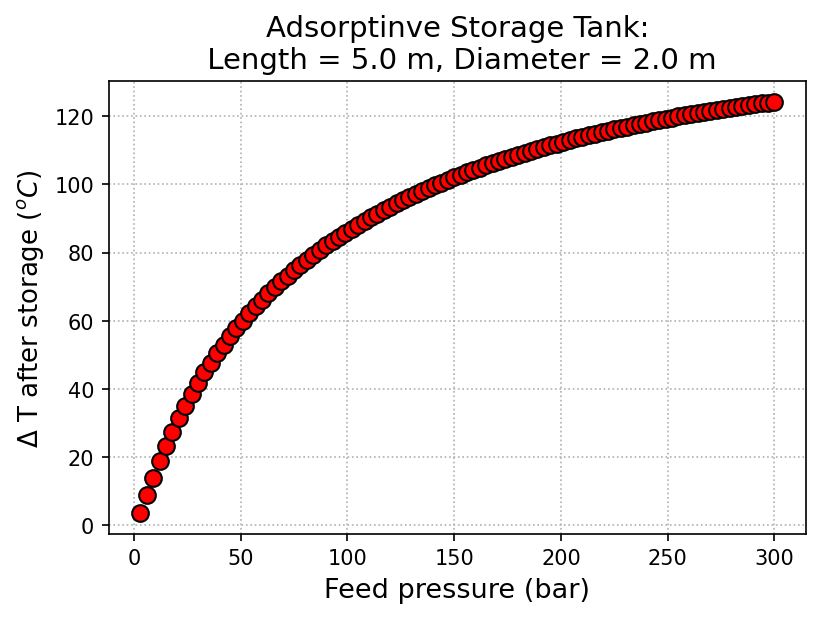

In [11]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, T_fin_list, 
        'o', color = 'k',markersize = 8,mfc = 'r')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

#plt.ylim([0, 68])
plt.grid(linestyle = ':')

# Surrogate Model

In [12]:
import scipy.optimize as optim

## Storage

In [13]:
def fn_guess(par,P):
    #T_return = par[0]*(par[1]*P)/(1+ par[1]*P) + par[2]*(par[3]*P)/(1+ par[3]*P)
    #del_m_return = par[0]*(par[1]*P**par[2])/(1+ par[1]*P**par[2])
    #del_m_return = par[0]*(par[1]*(P))/(1+ par[1]*(P))
    del_m_return = par[0]*(par[1]*(P-P_init)**par[2])/(1+ par[1]*(P-P_init)**par[2])
    return del_m_return 

def err_storage(par):
    #del_m_tmp = par[0]*par[1]*Pfeed_arr/(1+ par[1]*Pfeed_arr)
    del_m_tmp = fn_guess(par,Pfeed_arr[:])
    err = del_m_tmp - del_M_kg[:] / (rho_solid*L*A*(1-epsi))
    err_sq_sum = np.sum(err**2)
    return err_sq_sum
#es_opt = optim.shgo(err_storage, bounds=[[100,1000],[0,50]])
res_opt = optim.minimize(err_storage, x0 = [1, 0.005,0.8],
                        method = 'Nelder-mead')
print(res_opt)
res_opt_M = res_opt
psol = res_opt.x
P_ran = np.linspace(1,Pfeed_arr[-1],201)
del_M_pred = fn_guess(psol, P_ran)

 final_simplex: (array([[8.33747265e+00, 2.22726061e-04, 1.12024293e+00],
       [8.21652194e+00, 2.24482501e-04, 1.12174910e+00],
       [8.36078972e+00, 2.22303021e-04, 1.11981701e+00],
       [8.27103306e+00, 2.26113013e-04, 1.11898215e+00]]), array([0.00169722, 0.00173967, 0.00175456, 0.00176239]))
           fun: 0.0016972150719099996
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 601
           nit: 348
        status: 1
       success: False
             x: array([8.33747265e+00, 2.22726061e-04, 1.12024293e+00])


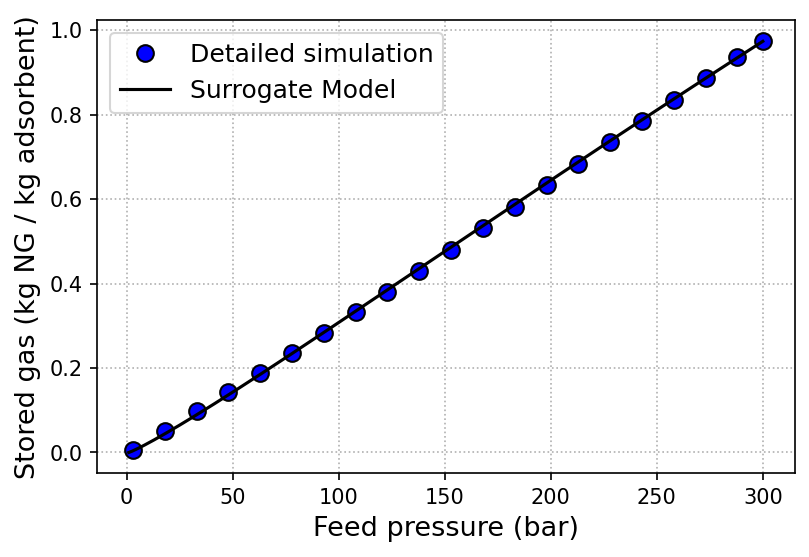

In [14]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.014])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
Pfeed_arr_new = np.concatenate([Pfeed_arr[::5], [Pfeed_arr[-1]]])
del_M_kg_ov_M_ad = np.concatenate([del_M_kg[::5]/ (rho_solid*L*A*(1-epsi)),[del_M_kg[-1]/ (rho_solid*L*A*(1-epsi))]] )
plt.plot(Pfeed_arr_new, del_M_kg_ov_M_ad,
         'o', color = 'k',markersize = 8,
         mfc = 'b',label = 'Detailed simulation')

#plt.plot(Pfeed_arr[::5], del_M_kg[::5]/ (rho_solid*L*A*(1-epsi)),
#         'o', color = 'k',markersize = 8, mfc = 'b',
#        label = 'Detailed simulation')
plt.plot(P_ran,del_M_pred,'k',label = 'Surrogate Model')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
#plt.ylabel('Stored gas (kg)', fontsize = 13)
plt.ylabel('Stored gas (kg NG / kg adsorbent)', fontsize = 13)

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
#plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m \n'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

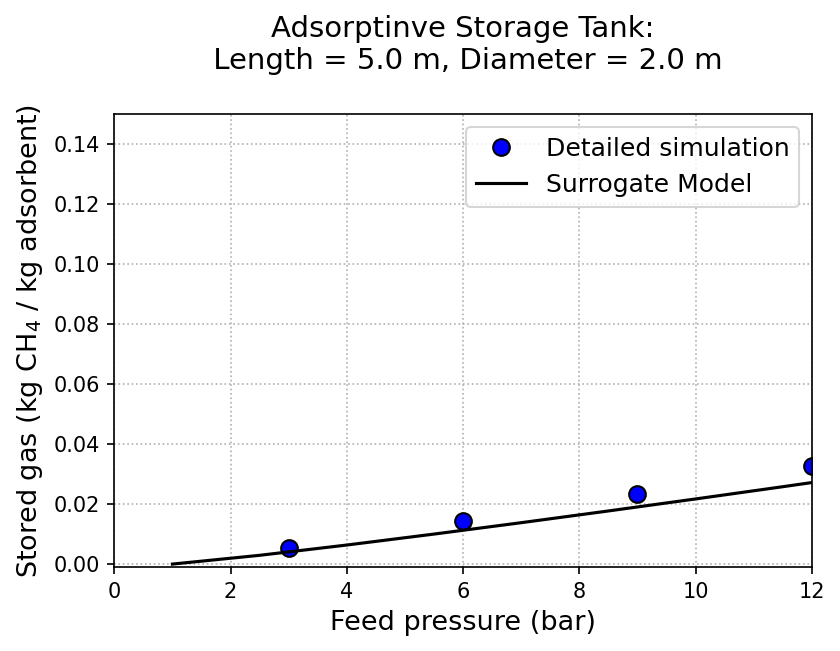

In [15]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.014])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, del_M_kg / (rho_solid*L*A*(1-epsi)),
         'o', color = 'k',markersize = 8, mfc = 'b',
        label = 'Detailed simulation')
plt.plot(P_ran,del_M_pred,'k',label = 'Surrogate Model')


plt.xlabel('Feed pressure (bar)', fontsize = 13)
#plt.ylabel('Stored gas (kg)', fontsize = 13)
plt.ylabel('Stored gas (kg CH$_{4}$ / kg adsorbent)', fontsize = 13)

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m\n'.format(Leng,Diam), fontsize = 14)
plt.xlim(0, 12)
plt.ylim(-0.001, 0.15)
plt.grid(linestyle = ':')

## Temperture Shift

In [16]:
print(Pfeed_arr[Pfeed_arr<1])

[]


In [17]:
def fn_guess(par,P):
    #T_return = par[0]*(par[1]*P)/(1+ par[1]*P) + par[2]*(par[3]*P)/(1+ par[3]*P)
    T_return = par[0]*(par[1]*(P-P_init)**par[2])/(1+ par[1]*(P-P_init)**par[2])
    return T_return
    
def err_tempshif(par):
    #del_m_tmp = par[0]*(2*par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)/(1+ par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)
    #del_m_tmp = par[0]*(2*par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)/(1+ par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)
    #del_m_tmp = par[0]*(par[1]*Pfeed_arr)/(1+ par[1]*Pfeed_arr) + par[2]*(par[3]*Pfeed_arr)/(1+ par[3]*Pfeed_arr)
    T_tmp = fn_guess(par,Pfeed_arr)
    err = T_tmp - np.array(T_fin_list)
    err_sq_sum = np.sum(err**2)
    return err_sq_sum
#res_opt = optim.shgo(err_storage, bounds=[[20,200],[0,10],[0,20],[0,100]])
res_opt = optim.minimize(err_tempshif, x0 = [112.6, 0.05, 0.9],
                        method = 'Nelder-Mead')
print(res_opt)
res_opt_T = res_opt
psol = res_opt.x
P_ran = np.linspace(Pfeed_arr[0],Pfeed_arr[-1],111)
T_fin_pred = fn_guess(psol, P_ran)

 final_simplex: (array([[1.60634249e+02, 1.27831666e-02, 9.81878751e-01],
       [1.60634233e+02, 1.27831446e-02, 9.81879163e-01],
       [1.60634320e+02, 1.27831727e-02, 9.81878399e-01],
       [1.60634295e+02, 1.27831771e-02, 9.81878444e-01]]), array([2.55376451, 2.55376451, 2.55376451, 2.55376452]))
           fun: 2.5537645092967622
       message: 'Optimization terminated successfully.'
          nfev: 236
           nit: 134
        status: 0
       success: True
             x: array([1.60634249e+02, 1.27831666e-02, 9.81878751e-01])


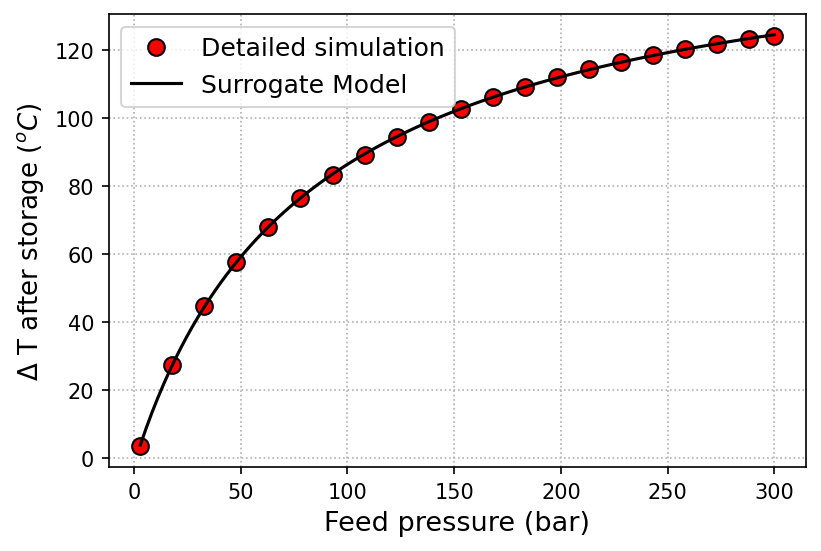

In [18]:
plt.figure(dpi = 150)

Pfeed_arr_new = np.concatenate([Pfeed_arr[::5],[Pfeed_arr[-1]]])
T_fin_list_new = np.concatenate([T_fin_list[::5], [T_fin_list[-1]]])

plt.plot(Pfeed_arr_new, T_fin_list_new, 
        'o', color = 'k',markersize = 8,mfc = 'r',
        label = 'Detailed simulation')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

plt.plot(P_ran,T_fin_pred,'k',label = 'Surrogate Model')

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
#plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m\n'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

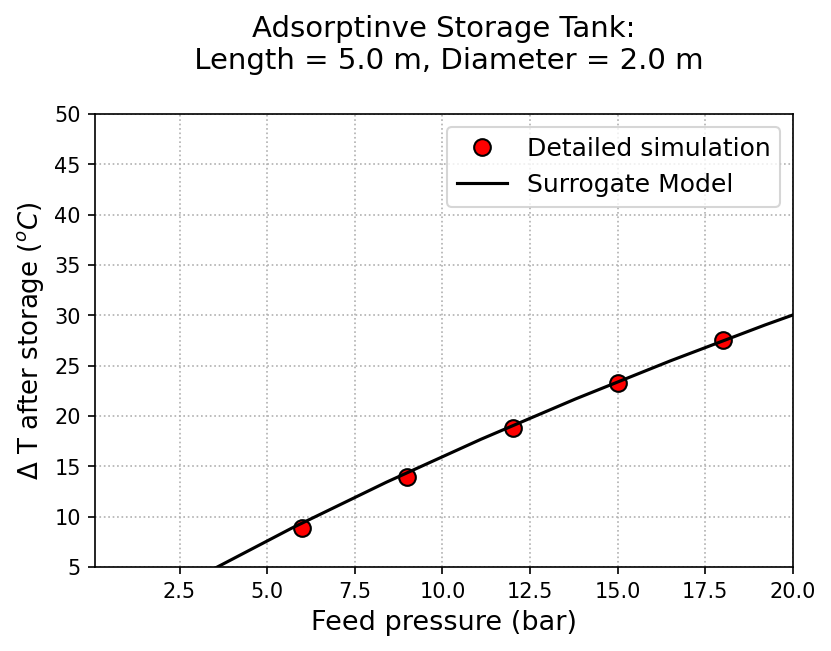

In [19]:

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, T_fin_list, 
        'o', color = 'k',markersize = 8,mfc = 'r',
        label = 'Detailed simulation')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

plt.plot(P_ran,T_fin_pred,'k',label = 'Surrogate Model')

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m\n'.format(Leng,Diam), fontsize = 14)

plt.xlim(0.1,20)
plt.ylim(5, 50)

plt.grid(linestyle = ':')

In [20]:
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('[[Final Result: Surrogate Model]]')
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print()
print('Mass capacity:')
print('M (kg CH4 / kg adsorbent) = ')
print('k1*k2*( P - P_init )^k3 / ( 1 + k2*( P - P_init )^k3 )')
print()
print('[k1 , k2, k3] = ')
print(res_opt_M.x)
print()
print()

print('Temperature difference:')
print('dT (K) = ')
print('j1*(j2*(P-P_init)**j3)/(1+ j2*(P-P_init)**j3)')
print()
print('[j1 , j2, j3] = ')
print(res_opt_T.x)
#a = input('enter any key to complete this.')


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
[[Final Result: Surrogate Model]]
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Mass capacity:
M (kg CH4 / kg adsorbent) = 
k1*k2*( P - P_init )^k3 / ( 1 + k2*( P - P_init )^k3 )

[k1 , k2, k3] = 
[8.33747265e+00 2.22726061e-04 1.12024293e+00]


Temperature difference:
dT (K) = 
j1*(j2*(P-P_init)**j3)/(1+ j2*(P-P_init)**j3)

[j1 , j2, j3] = 
[1.60634249e+02 1.27831666e-02 9.81878751e-01]


In [21]:
print('Specific \nCapacity (kg/kg) \nat 300 bar =')
print()
print( del_M_kg[-1]/ ((1-epsi)*A*L*rho_solid)  )
print('(kg/kg)')

Specific 
Capacity (kg/kg) 
at 300 bar =

0.974804200993148
(kg/kg)
